In [146]:
#!pip3 install 'gast==0.2.2'

## Play with the analytical Bayes fit

**Goal:** Compare 

**Usage:** 

**Dataset:** Artificial Data

**Content:**

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0
        !pip install tensorflow-probability==0.8.0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0
TF  Version 2.0.0


### Define functions for Bayes 

See nb_ch_07_02

In [3]:
def make_design_matrix(x):
    return np.hstack((np.ones((len(x),1)), x))

def posterior(x, y, one_over_var0, var):
    """
        x vector with training x data
        y vector with training y values
        one_over_var0 1/𝜎0^2 the variances of the prior distribution
        var is the assumed to be known variance of data
        @returns mean vector mu and covariance Matrix Sig 
    """
    X = make_design_matrix(x)
    Sig_inv = one_over_var0 * np.eye(X.shape[1]) + X.T.dot(X) / var
    Sig = np.linalg.inv(Sig_inv)
    mu = Sig.dot(X.T).dot(y) / var
    return mu, Sig

def posterior_predictive(x_test, mu, Sig, var):
    """
        x_test the positions, where the posterior is to be evaluated
        mu the mean values of the weight-posterior
        Sig the covariance matrix 
        var is the assumed to be known variance of data 
        Computes mean and variances of the posterior predictive distribution of y
    """
    X_test = make_design_matrix(x_test)
    y = X_test.dot(mu)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = var + np.sum(X_test.dot(Sig) * X_test, axis=1)  
    return y, y_var

### Create Data 4 Points
See nb_ch_07_02

In [8]:
xmin = -5;xmax = +5;ymin=-40;ymax=40;sigma=3
save = True
np.random.seed(2)
num = 4
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 
if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('nb_ch07_lr_artifical{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e'); 



### Maximum Likelihood Fit for the 4 points

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


Text(0.5, 1.0, 'a = +2.92 b = -1.73')

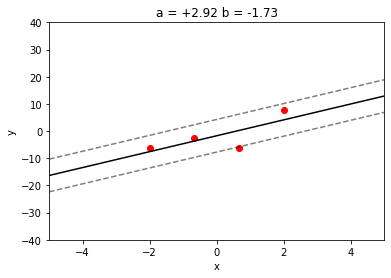

In [9]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)
a = a_ml[0]
b = b_ml

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
plt.plot([xmin, xmax], [a*xmin+b+2*sigma, a*xmax+b+2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.plot([xmin, xmax], [a*xmin+b-2*sigma, a*xmax+b-2*sigma], linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y, marker='o', color='r')
plt.title('a = {:+.2f} b = {:+.2f}'.format(a,b))  

### Bayes fit for the 4 points

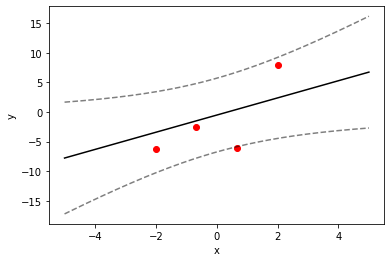

In [38]:
sigma_0 = 1
xs = np.linspace(xmin,xmax,250).reshape((250,1))
m, Sigma = posterior(x, y, 1/sigma_0**2, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 
ax = plt.gca()
plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,color='r')

### Prior and Posterior

In [39]:
norm = tfd.MultivariateNormalDiag(loc=(0,0), scale_diag=(1,1))
norm.prob((1.0,2.0))

<tf.Tensor: id=672286, shape=(), dtype=float32, numpy=0.013064231>

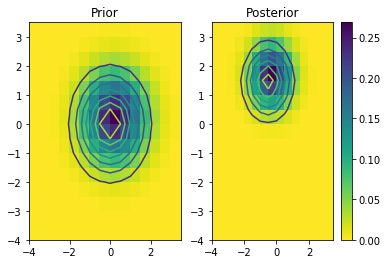

In [64]:
ai=np.arange(-4, 4, 0.5)
bi=np.arange(-4, 4, 0.5)
X, Y = np.meshgrid(ai, bi)
norm = tfd.MultivariateNormalDiag(loc=(0,0), scale_diag=(1,1))

def f(a,b):
    return norm.prob((a,b)).numpy()

zs = np.array([f(a,b) for a,b in zip(np.ravel(X), np.ravel(Y))])
zs=zs.reshape(X.shape)

cmap = plt.get_cmap('viridis_r',)
plt.subplot(1,2,1)
plt.pcolormesh(ai, bi, zs, cmap=cmap)
#plt.colorbar()
plt.contour(ai, bi, zs)#,[scipy.stats.norm(0, sigma).pdf(2*sigma)])
plt.title('Prior')


m, Sigma = posterior(x, y, 1/sigma_0**2, sigma**2)
norm = tfd.MultivariateNormalFullCovariance(loc=m, covariance_matrix=Sigma)
def f(a,b):
    return norm.prob((a,b)).numpy()

zs = np.array([f(a,b) for a,b in zip(np.ravel(X), np.ravel(Y))])
zs=zs.reshape(X.shape)

plt.subplot(1,2,2)
plt.title('Posterior')
plt.pcolormesh(ai, bi, zs, cmap=cmap)
plt.colorbar()
plt.contour(ai, bi, zs)#,[scipy.stats.norm(0, sigma).pdf(2*sigma)])

### Predictive Distribution

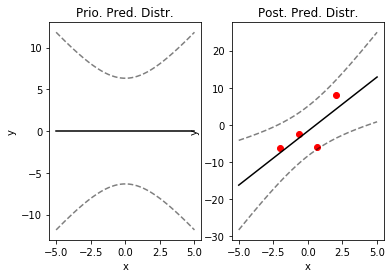

In [75]:
m, Sigma = posterior(x, y, 0.0, sigma**2)
m=(0,0)
Sigma = [[1,0],[0,1]]
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)

plt.subplot(1,2,1)
plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prio. Pred. Distr.')

plt.subplot(1,2,2)
m, Sigma = posterior(x, y, 0.0, sigma**2)
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 

plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.title('Post. Pred. Distr.')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,color='r')




## Simulation Study 

To show also the positive effect on prediction preformance, also in the interpolation case...

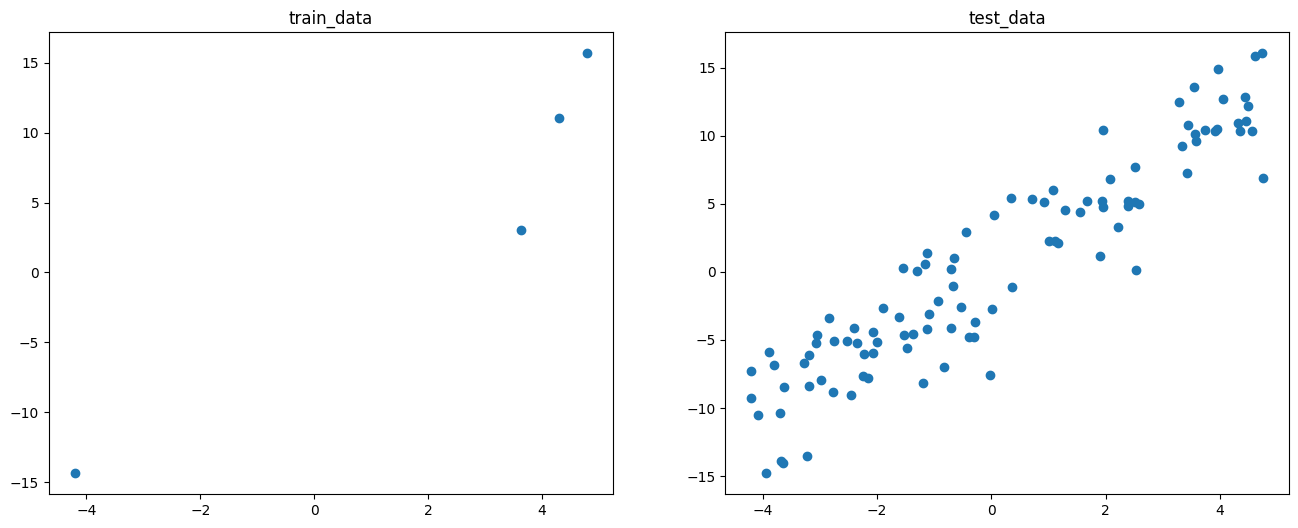

In [69]:
def get_data(N_train, N_test,sigma):
    x=np.random.uniform(-5,5,size=N_train)
    noise=np.random.normal(loc=0,scale=sigma,size=N_train)# const var
    y=2.7*x+noise #y linear model with const var
    y_train=y.reshape((len(y),1))
    x_train=x.reshape((len(x),1))
    x_test=np.random.uniform(min(x_train),max(x_train),size=N_test)
    noise=np.random.normal(loc=0,scale=sigma,size=N_test)# const var
    y_test=2.7*x_test+noise #y linear model with const var
    y_test=y_test.reshape((len(y_test),1))
    x_test=x_test.reshape((len(x_test),1))
    return x_train, y_train, x_test, y_test
  
N_train = 4
N_test  = 100
sigma = 3
x_train, y_train, x_test, y_test = get_data(N_train, N_test,sigma)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.title("train_data")
plt.subplot(1,2,2)
plt.scatter(x_test, y_test)
plt.title("test_data")
plt.show()

In [70]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()

def get_nll_lin(x_train, y_train,x_test,y_test):
    res = model_skl.fit(x_train, y_train)
    r2 = (y_test - model_skl.predict(x_test))**2
    nll = N_test*np.log(np.sqrt(2*np.pi*sigma**2)) + np.sum((r2/(2*sigma**2)))
    return nll/len(y_test),res.coef_,res.intercept_

### Bayes

In [73]:
def get_nll_bayes(x_train, y_train,x_test, y_test):
    #beta =  1.0 / sigma**2
    alpha = 1.0 #Prior

    # Mean and covariance matrix of posterior
#     Phi = expand(x_train, identity_basis_function) #Designmatrix
    m, S = posterior(x_train, y_train, alpha, sigma**2)
    #Phi_test = expand(x_test, identity_basis_function)
    # Mean and variances of posterior predictive 
    yt, yt_var = posterior_predictive(x_test, m, S, sigma**2)
    nll = 0
    for i in range(N_test):
        n = tfd.Normal(loc=yt[i], scale=np.sqrt(yt_var[i])) #TODO make for all N_train at once
        nll += n.log_prob(y_test[i])
    return -nll/len(y_test),m[1],m[0]


### Bayes for large number of training data is MaxLike 

In [75]:
N_train = 100 #Large number of training Bayes should be similar to MaxLike
x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll)

Coefficients a_ml:  [2.77052407] Coefficients b_ml [0.15159151]  nll (per data point) 2.499345665676767
Coefficients a_bayes:  2.742672868179978 Coefficients b_ml [0.14168655]  nll (per data point) tf.Tensor([2.49867625], shape=(1,), dtype=float64)


### Small number of training data

Now the epistemics uncertainty become important  

In [76]:
N_train = 4 #Small Bayes
x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

Coefficients a_ml:  [4.04469667] Coefficients b_ml [-6.84261874]  nll (per data point) 0.026444709432399717
Coefficients a_bayes:  1.9701192307146431 Coefficients b_ml [0.28808915]  nll (per data point) tf.Tensor([0.02643294], shape=(1,), dtype=float64)


In [117]:
import tqdm
N_train = 2

runs = 100
nll_bayes = np.zeros(runs)
nll_max_like = np.zeros(runs)
for i in range(runs):
    x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)
    m,_,_= get_nll_lin(x_train, y_train, x_test, y_test)
    nll_max_like[i] = m
    b ,_,_ = get_nll_bayes(x_train, y_train, x_test, y_test)
    nll_bayes[i] = b

Text(0, 0.5, 'nll_bayes')

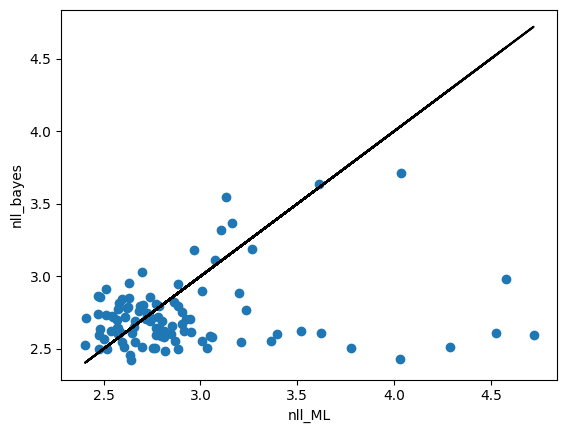

In [118]:
plt.scatter(nll_max_like, nll_bayes)
plt.plot(nll_max_like,nll_max_like,'k-') # identity line
plt.xlabel('nll_ML')
plt.ylabel('nll_bayes')


2.7287503654700562
2.8972762383863273


Text(0.5, 1.0, 'test NLL MaxLike')

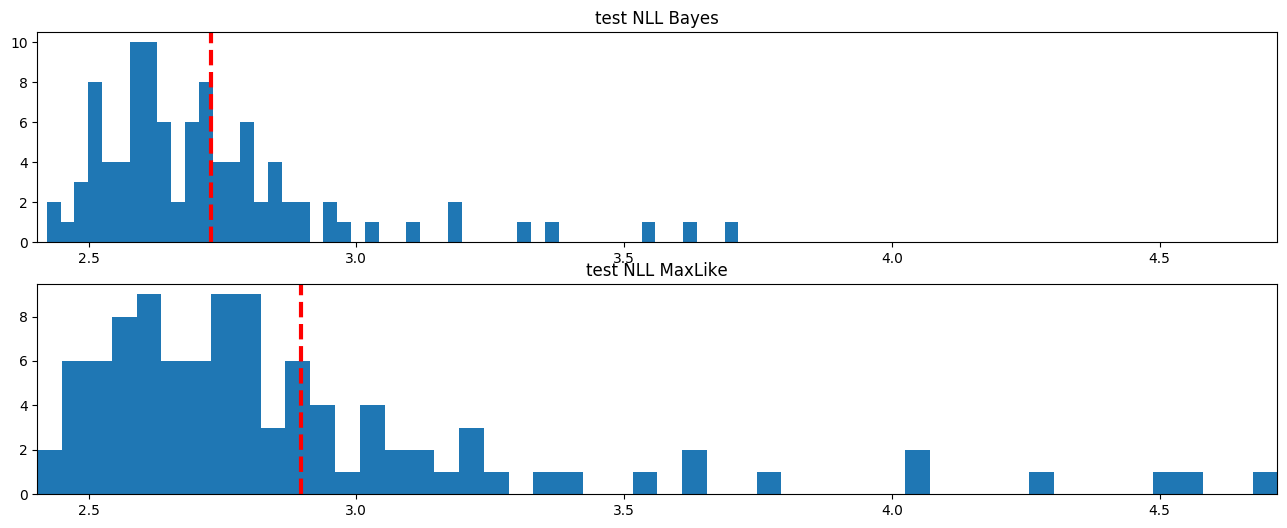

In [119]:
mean_bayes= np.mean(nll_bayes)
print(mean_bayes)
mean_ml = np.mean(nll_max_like)
print(mean_ml)

plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
x_min = np.min((nll_bayes, nll_max_like))
x_max = np.max((nll_max_like, nll_max_like))

plt.hist(nll_bayes,50)
plt.xlim(x_min,x_max)
plt.axvline(mean_bayes, color='r', linestyle='dashed', linewidth=3)
plt.title('test NLL Bayes')

plt.subplot(2,1,2)
plt.hist(nll_max_like,50)
plt.xlim(x_min,x_max)
plt.axvline(mean_ml, color='r', linestyle='dashed', linewidth=3)
plt.title('test NLL MaxLike')



In [107]:
np.min((nll_bayes, nll_max_like))

2.3429542189134427

In [135]:
N_test = 100
runs = 100
N_trains = (2,3,4,10,20,100)
maxlike = np.zeros((len(N_trains),3))
bayes = np.zeros((len(N_trains),3))

for n,N_train in enumerate(N_trains):
    print(N_train, ' ', N_test)
    nll_bayes = np.zeros(runs)
    nll_max_like = np.zeros(runs)
    for i in range(runs):
        x_train, y_train, x_test, y_test = get_data(N_train, N_test, sigma)
        m,_,_= get_nll_lin(x_train, y_train, x_test, y_test)
        nll_max_like[i] = m
        
        b ,_,_ = get_nll_bayes(x_train, y_train, x_test, y_test)
        nll_bayes[i] = b
    maxlike[n,0] = np.mean(nll_max_like)
    maxlike[n,1] = np.std(nll_max_like)
    maxlike[n,2] = np.median(nll_max_like)
    bayes[n,0]= np.mean(nll_bayes)
    bayes[n,1]= np.std(nll_bayes)
    bayes[n,2]= np.median(nll_bayes)

2   100
3   100
4   100
10   100
20   100
100   100


In [128]:
bayes

array([[3.38746008e+00, 0.00000000e+00, 3.38746008e+00],
       [2.54962857e+00, 0.00000000e+00, 2.54962857e+00],
       [2.63292607e+00, 0.00000000e+00, 2.63292607e+00],
       [2.61531640e+00, 4.44089210e-16, 2.61531640e+00],
       [2.57955879e+00, 4.44089210e-16, 2.57955879e+00],
       [2.62283853e+00, 0.00000000e+00, 2.62283853e+00]])

Text(0, 0.5, 'Average NLL (per test point)')

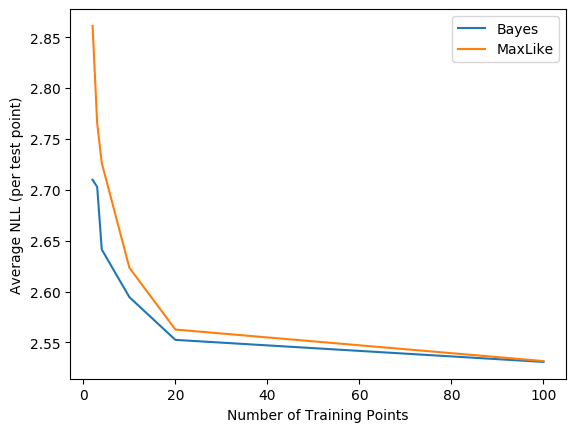

In [144]:
#plt.plot(range(len(N_trains)), bayes[:,0])
#plt.plot(range(len(N_trains)), maxlike[:,0])
plt.plot(N_trains, bayes[:,0])
plt.plot(N_trains, maxlike[:,0])

plt.legend(['Bayes','MaxLike'])
plt.xlabel('Number of Training Points')
plt.ylabel('Average NLL (per test point)')

Text(0, 0.5, 'Std NLL (per test point)')

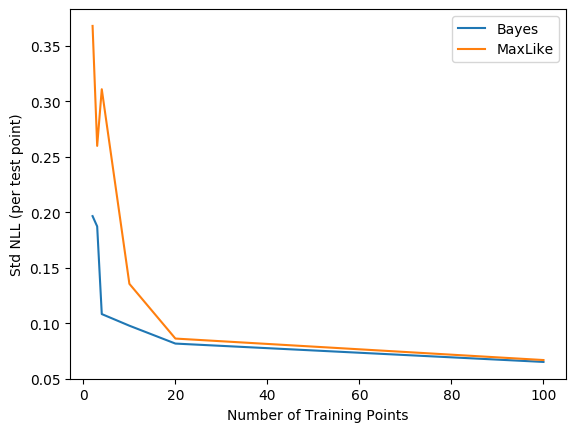

In [145]:
plt.plot(N_trains, bayes[:,1])
plt.plot(N_trains, maxlike[:,1])

plt.legend(['Bayes','MaxLike'])
plt.xlabel('Number of Training Points')
plt.ylabel('Std NLL (per test point)')